# HOW THIS EMI-RECEIVER ALGORITHM WORK ? 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt , pi

In [2]:
# Initialization 
bl= '#1520c0' # blue 
rd= '#C62828' # red

# GENERATE THE TIME SIGNAL 

In [3]:
Ts=1e-7 # s
Fs=1/Ts # Hs
print(f"Fs = {Fs*1e-6} MHz")

Fs = 10.0 MHz


Text(0, 0.5, 'frequancy sweep')

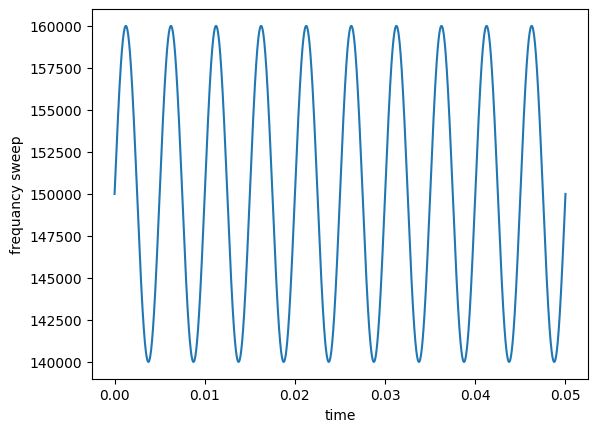

In [4]:
tm= 50e-3 # measuring time : ms
t= np.arange(0,tm+Ts, Ts)
fsweep= 200 # sweep freq = 2kHz 
Freq_sweep= 150e3+10e3*np.sin(fsweep*2*pi*t)
plt.plot(t, Freq_sweep)
plt.xlabel("time")
plt.ylabel("frequancy sweep")

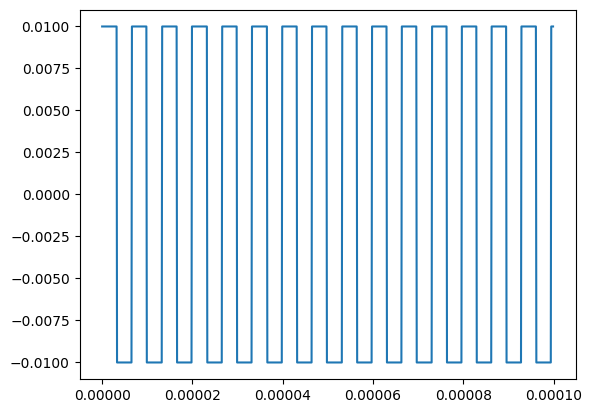

In [5]:
# signal with freq sweep 
Amp= 10e-3 # 10 mV
v1 = 2*Amp*(np.sin(2*pi*np.cumsum(Freq_sweep)*Ts)>0)-Amp
plt.plot(t[:1000],v1[:1000])

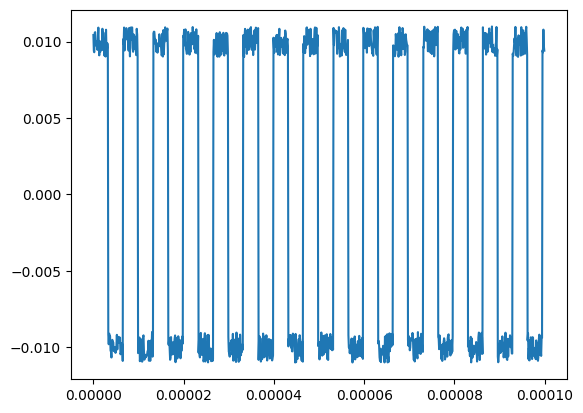

In [6]:
# add noise 
Amp_noise = 1000e-6 # 200µv
v2 = np.random.uniform(low = -Amp_noise, high =Amp_noise, size  = len(v1))
v12 = v1+v2
plt.plot(t[:1000],v12[:1000])

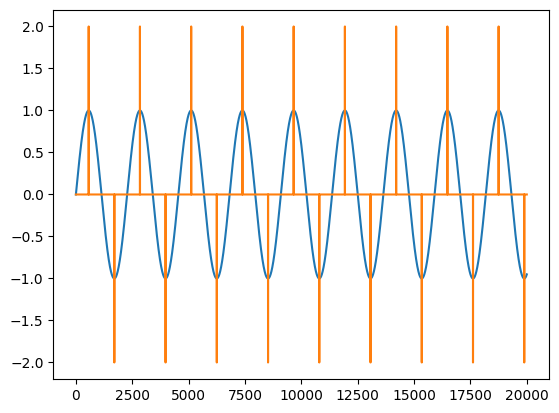

pulse time = 3.1999999999999997 µs


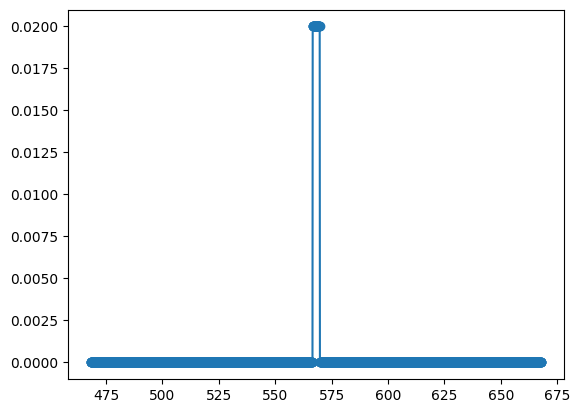

In [7]:
# Pulse in the isgnal 
freq_pulse = 440 # 1kHz 
v3= np.sin(2*pi*freq_pulse*t)# 1000kHz 
plt.plot(t[:200000]*1e6,v3[:200000])
mask=np.abs(v3)>0.99999
v32 = (mask)*0.03
v32[mask]= v3[mask]*0.02
plt.plot(t[:200000]*1e6, 100*v32[:200000])

plt.show()

n=int((Fs/freq_pulse)/4)
plt.plot(t[n-1000:n+1000]*1e6, v32[n-1000:n+1000], marker = "o")

mask =v32[n-1000:n+1000] >0
print(f"pulse time = {1e6*mask.sum()*Ts} µs")

In [8]:
v4= v32+v12 
#plt.plot(t[:1000_000],v4[:1000_000])

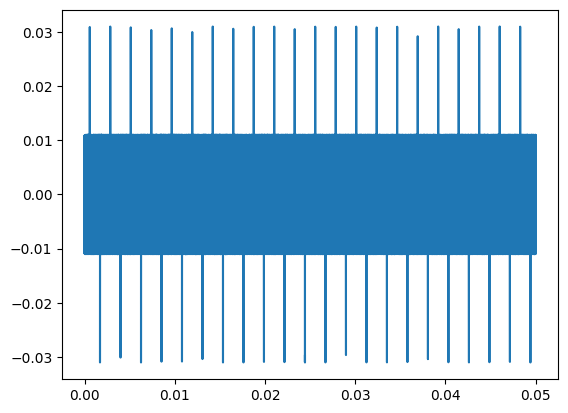

In [9]:
# final signal 
plt.plot(t,v4)

# Use the package to make EMI receiver

In [10]:
# %pip install emi-receiver
from emi_receiver import receiver

In [11]:
freqs, peak, avg, qp = receiver(v4, 1/Ts, rbw=9000, band='B')

--------------------------------------------------
EMI Receiver Configuration:
  RBW           : 9000 Hz
  Step Size     : 2500.00 Hz (Target: 2500 Hz)
  Window Size   : 2499 samples
  FFT Size      : 4000 samples (Zero-Padding: True)
  Detector Time : 0.025 ms
--------------------------------------------------


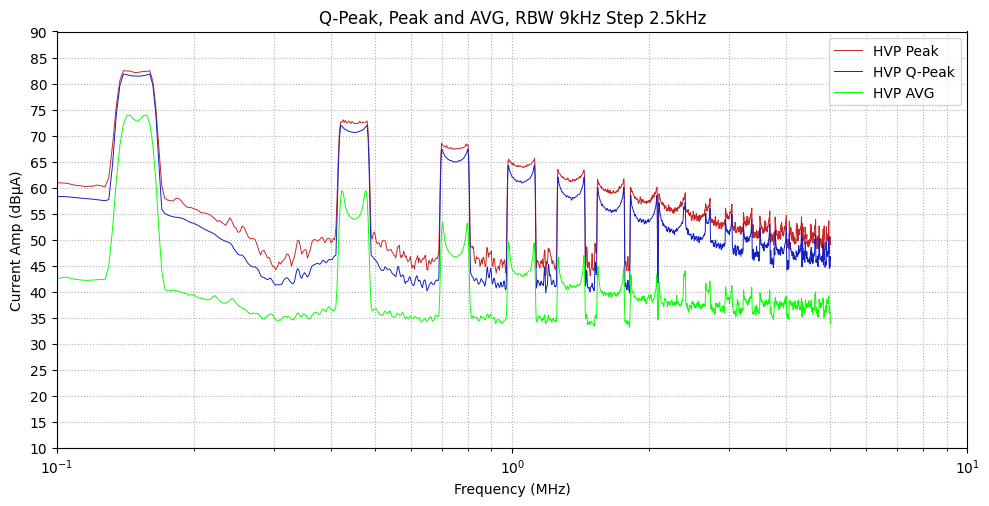

In [12]:
title="Q-Peak, Peak and AVG, RBW 9kHz Step 2.5kHz"
plt.figure(figsize=(10,5))




plt.semilogx(freqs*1e-6, peak, label='Peak', color=rd, linewidth=0.7)  
plt.semilogx(freqs*1e-6, qp, label='Q-Peak', color=bl, linewidth=0.7)  
plt.semilogx(freqs*1e-6, avg, label='AVG', color="#0AFF03", linewidth=0.7) 
amax = 90
amin = 10

plt.ylim(amin, amax)
plt.yticks(np.arange(amin, amax+1, 5))
plt.grid(True)

plt.grid(True, which='both', ls=':')
plt.xlabel('Frequency (MHz)')
plt.xlim([0.1, 10])
plt.ylabel('Current Amp (dBµA)')
plt.legend()
plt.tight_layout()
plt.title(title)
plt.show()

# UNDERSTUND THE ALGO LOCALLY

In [13]:
import numpy as np
import scipy.signal
import scipy.fft
from numba import jit

### THE RBW WINDWOS 

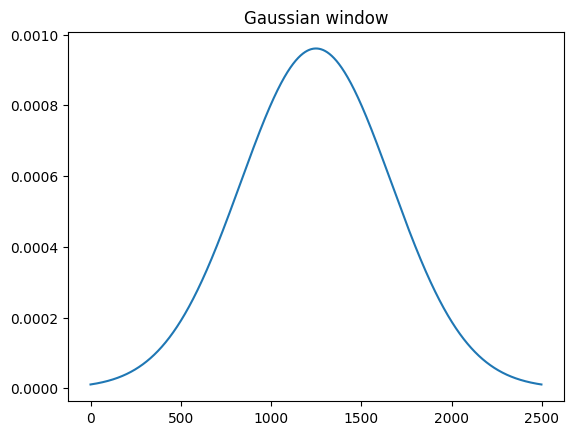

In [51]:


rbw = 9e3 # 9kHz 
fs = Fs
step =2.5e3 # 2.5khz 
# --- B. Design the "RBW" Window ---
# We need a Gaussian window where the 6dB bandwidth equals RBW.
sigma_f = rbw / (2 * np.sqrt(2 * np.log(2)))
sigma_t = 1.0 / (2 * np.pi * sigma_f)

# Window length (Physical Filter Width)
win_len_sec = 6 * sigma_t 
nperseg = int(win_len_sec * fs)
if nperseg % 2 == 0: nperseg += 1

# --- C. Configure FFT Step Size ---
# Formula: Step = Fs / Nfft

nfft = nperseg


# Generate Gaussian Window
sigma_samples = sigma_t * fs
window = scipy.signal.windows.gaussian(nperseg, std=sigma_samples)

# Normalize Window Energy (Sum=1 ensures correct amplitude after FFT)
window = window / np.sum(window) 

plt.plot(window )
plt.title("Gaussian window")



# --- D. Overlap Configuration ---
# 90% Overlap is standard for FFT-Scan to capture transient peaks
overlap_ratio = 0.90 
noverlap = int(nperseg * overlap_ratio)
step_size = nperseg - noverlap
# step_size = 2499
# nperseg, len(window) =(24985, 24985)

# Detector Timing
fs_detector = fs / step_size
dt_detector = 1.0 / fs_detector

In [53]:
index = np.arange(0,len(v4),step_size) # nperseg)
for i in index: 
    if i+nperseg < len(v4):
        sig=v4[i:i+nperseg]
    break

In [54]:
sig.shape, window.shape, (sig*window).shape

((2499,), (2499,), (2499,))

Text(0.5, 1.0, 'window*Signal')

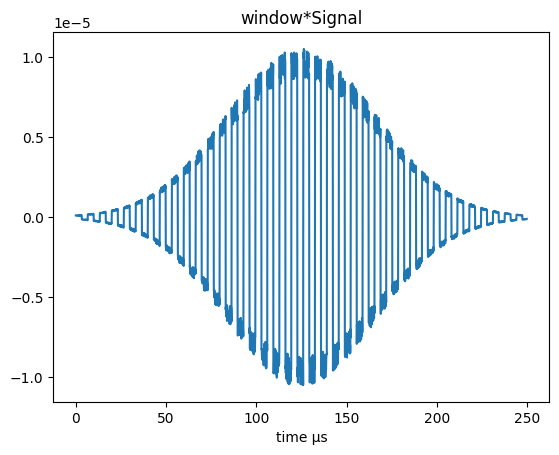

In [57]:
plt.plot(t[:len(sig)]*1e6, sig*window)
plt.xlabel("time µs")
plt.title("window*Signal")

### Sliding Window (STFT) loop with 90% of overlaping

CPU times: total: 15.6 ms
Wall time: 11.6 ms


Text(0.5, 1.0, 'windowing without padding')

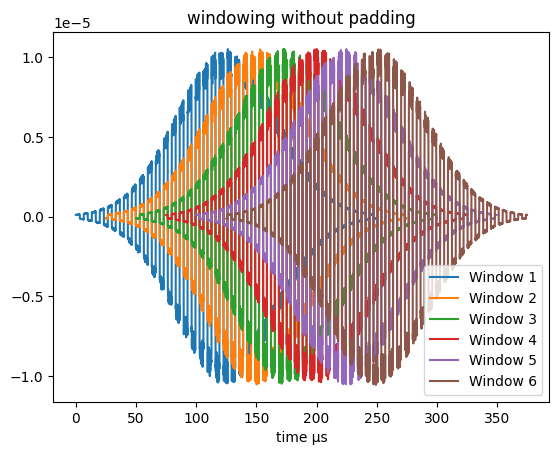

In [50]:
%%time 
index = np.arange(0,len(v4),step_size) 
Zxx=[]
t_axis = []
k=0
for i in index: 
    if i+nperseg < len(v4):
        # cut the signal 
        sig= v4[i:i+nperseg]
        # apply the window 
        sig = sig*window
        k=k+1
        plt.plot(t[i:i+nperseg]*1e6, sig, label = f"Window {k}")
        if k>5:
            break
plt.legend()
plt.xlabel("time µs")
plt.title("windowing without padding")
            

### TIME FREQ FFT (2D)

In [20]:
# USE SCIPY PACKAGE 

In [21]:
# --- E. Perform STFT ---
# padded=True allows signal to be handled at boundaries

f_axis2, t_axis2, Zxx2 = scipy.signal.stft(
    v4, fs, 
    window=window, 
    nperseg=nperseg,    # Controls RBW Physics
    noverlap=noverlap, 
    nfft=nfft,          # Controls Frequency Step (Display)
    boundary='zeros',
    padded=True
)

In [22]:
### UNDERSTUNG SCIPY PACKAGE

In [23]:
%%time 
index = np.arange(0,len(v4),step_size) 
Zxx=[]
t_axis = []
for i in index: 
    if i+nperseg < len(v4):
        # cut the signal 
        sig= v4[i:i+nperseg]
        # apply the window 
        sig = sig*window
        # fft
        fftsig= np.fft.fft(sig)
        # keep the first half + DC
        fftsig=fftsig[:nperseg//2 + 1] 
        Zxx.append(fftsig)
        # time point as center
        t_axis .append((i + nperseg / 2) / fs)

f_axis= np.fft.fftfreq(len(sig), 1/fs)[:nperseg//2 + 1]
Zxx = np.array(Zxx).T 
t_axis = np.array(t_axis)

CPU times: total: 422 ms
Wall time: 608 ms


In [26]:
import seaborn as sns

In [27]:
print("#", f_axis2.shape, t_axis2.shape, Zxx2.shape)
print("#", f_axis.shape, t_axis.shape, Zxx.shape)
# (12493,) (2002,) (12493, 2002)
# (12493,) (1991,) (12493, 1991)

# (1250,) (2002,) (1250, 2002)
# (1250,) (1991,) (1250, 1991)


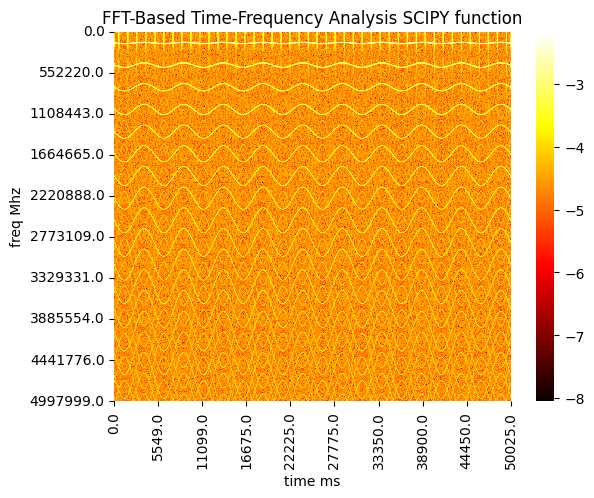

In [28]:
ax = sns.heatmap(np.log10(np.abs(Zxx2)), cmap='hot')

nx = min(10, len(t_axis2)); ix = np.linspace(0, len(t_axis2)-1, nx, dtype=int)
ny = min(10, len(f_axis2)); iy = np.linspace(0, len(f_axis2)-1, ny, dtype=int)

ax.set_xticks(ix); ax.set_xticklabels(np.floor(t_axis2[ix]*1e6))
ax.set_yticks(iy); ax.set_yticklabels(np.floor(f_axis2[iy]))

plt.title("FFT-Based Time-Frequency Analysis SCIPY function")
plt.xlabel("time ms")
plt.ylabel("freq Mhz")

plt.show()

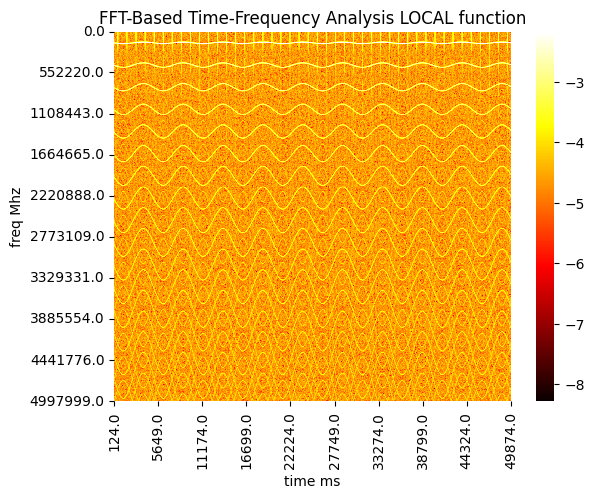

In [29]:
ax = sns.heatmap(np.log10(np.abs(Zxx)), cmap='hot')

nx = min(10, len(t_axis)); ix = np.linspace(0, len(t_axis)-1, nx, dtype=int)
ny = min(10, len(f_axis)); iy = np.linspace(0, len(f_axis)-1, ny, dtype=int)

ax.set_xticks(ix); ax.set_xticklabels(np.floor(t_axis[ix]*1e6))
ax.set_yticks(iy); ax.set_yticklabels(np.floor(f_axis[iy]))

plt.title("FFT-Based Time-Frequency Analysis LOCAL function")
plt.xlabel("time ms")
plt.ylabel("freq Mhz")

plt.show()

### Add 0 padding

In [30]:
%%time 
# add 0 in the begining and in the end to take all measurement time
pad_w = nperseg // 2
v4_pad = np.pad(v4, (pad_w, pad_w), mode='constant')


index = np.arange(0,len(v4_pad ),step_size) 
Zxx=[]
t_axis = []
for i in index: 
    #if i+nperseg < len(v4):
    #if i + nperseg < len(v4_pad):
    if i + nperseg <= len(v4_pad):
        # cut the signal 
        sig= v4_pad [i:i+nperseg]
        # apply the window 
        sig = sig*window
        # fft
        fftsig= np.fft.fft(sig)
        # keep the first half + DC
        fftsig=fftsig[:nperseg//2 + 1] 
        Zxx.append(fftsig)
        # time point as center
        t_val = ((i + nperseg / 2) - pad_w) / fs
        t_axis .append(t_val)

f_axis= np.fft.fftfreq(len(sig), 1/fs)[:nperseg//2 + 1]
Zxx = np.array(Zxx).T 
t_axis = np.array(t_axis)

CPU times: total: 578 ms
Wall time: 667 ms


CPU times: total: 0 ns
Wall time: 10.7 ms


Text(0.5, 1.0, 'windowing without with padding')

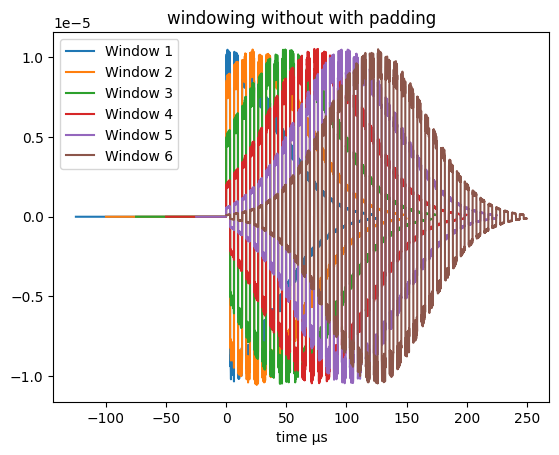

In [58]:
%%time 
index = np.arange(0,len(v4_pad ),step_size)
k=0
for i in index: 
    if i+nperseg < len(v4):
        # cut the signal 
        sig= v4_pad[i:i+nperseg]
        # apply the window 
        sig = sig*window
        k=k+1
        plt.plot(t[i:i+nperseg]*1e6-pad_w *Ts*1e6, sig, label = f"Window {k}")
        if k>5:
            break
plt.legend()
plt.xlabel("time µs")
plt.title("windowing without with padding")
            
            

In [32]:
print("#", f_axis2.shape, t_axis2.shape, Zxx2.shape)
print("#", f_axis.shape, t_axis.shape, Zxx.shape)
# (1250,) (2002,) (1250, 2002)
# (1250,) (2001,) (1250, 2001)

# (1250,) (2002,) (1250, 2002)
# (1250,) (2001,) (1250, 2001)


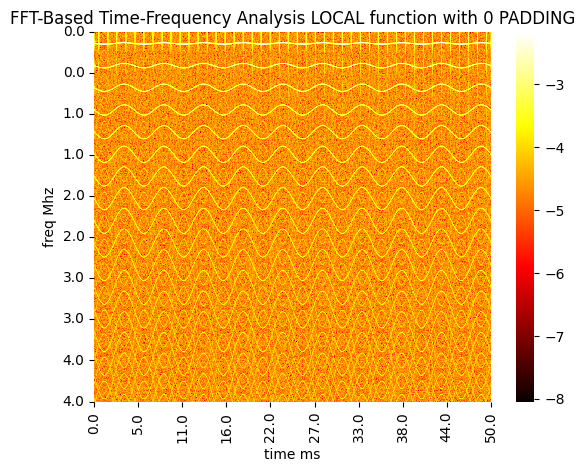

In [33]:
ax = sns.heatmap(np.log10(np.abs(Zxx)), cmap='hot')

nx = min(10, len(t_axis)); ix = np.linspace(0, len(t_axis)-1, nx, dtype=int)
ny = min(10, len(f_axis)); iy = np.linspace(0, len(f_axis)-1, ny, dtype=int)

ax.set_xticks(ix); ax.set_xticklabels(np.floor(t_axis[ix]*1e3))
ax.set_yticks(iy); ax.set_yticklabels(np.floor(f_axis[iy]*1e-6))


plt.title("FFT-Based Time-Frequency Analysis LOCAL function with 0 PADDING")
plt.xlabel("time ms")
plt.ylabel("freq Mhz")

plt.show()

# PEAK AND AVG DETECTORS 

In [34]:
print("#", f_axis.shape, t_axis.shape, Zxx.shape)

# (1250,) (2001,) (1250, 2001)


In [35]:
# detector 
mag = 2*np.abs(Zxx) 
# we use one side of frequ, so to conserve energy x2 is necessery
AVG = mag.mean(axis = 1)
PEAK = mag.max(axis = 1)
# qp to be done after 
print("#", f_axis.shape,AVG.shape)

# (1250,) (1250,)


In [36]:
# dbuv = 20*log10(mag*1e6), 1µV = 1e6 volte 
AVGdb = 20*np.log10(AVG*1e6)
PEAKdb = 20*np.log10(PEAK*1e6)

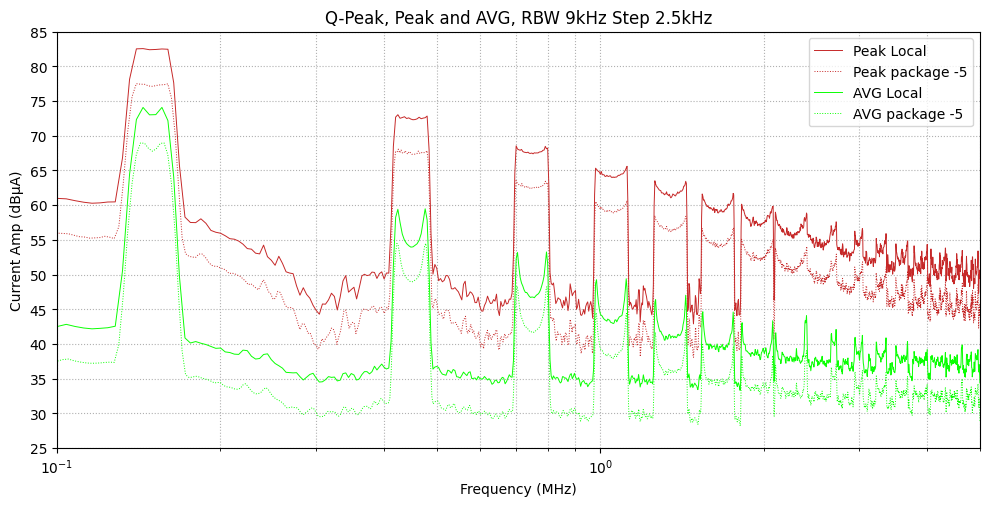

In [46]:
title="Q-Peak, Peak and AVG, RBW 9kHz Step 2.5kHz"
plt.figure(figsize=(10,5))




plt.semilogx(f_axis*1e-6, PEAKdb, label='Peak Local', color=rd, linewidth=0.7)  
plt.semilogx(freqs*1e-6, peak-5, label='Peak package -5', color=rd, linewidth=0.7, linestyle = "dotted")


#plt.semilogx(f_axis*1e-6, QPEAKdb, label='Q-Peak Local', color=bl, linewidth=0.7)  
#plt.semilogx(freqs*1e-6, qp-5, label='Q-Peak package -5', color=bl, linewidth=0.7, linestyle = "dotted") 


plt.semilogx(f_axis*1e-6, AVGdb, label='AVG Local', color="#0AFF03", linewidth=0.7) 
plt.semilogx(freqs*1e-6, avg-5, label='AVG package -5', color="#0AFF03", linewidth=0.7, linestyle = "dotted")

amax = 85
amin = 25

plt.ylim(amin, amax)
plt.yticks(np.arange(amin, amax+1, 5))
plt.grid(True)

plt.grid(True, which='both', ls=':')
plt.xlabel('Frequency (MHz)')
plt.xlim([0.1, 5])
plt.ylabel('Current Amp (dBµA)')
plt.legend()
plt.tight_layout()
plt.title(title)
plt.show()

# QPEAK DETECTOR

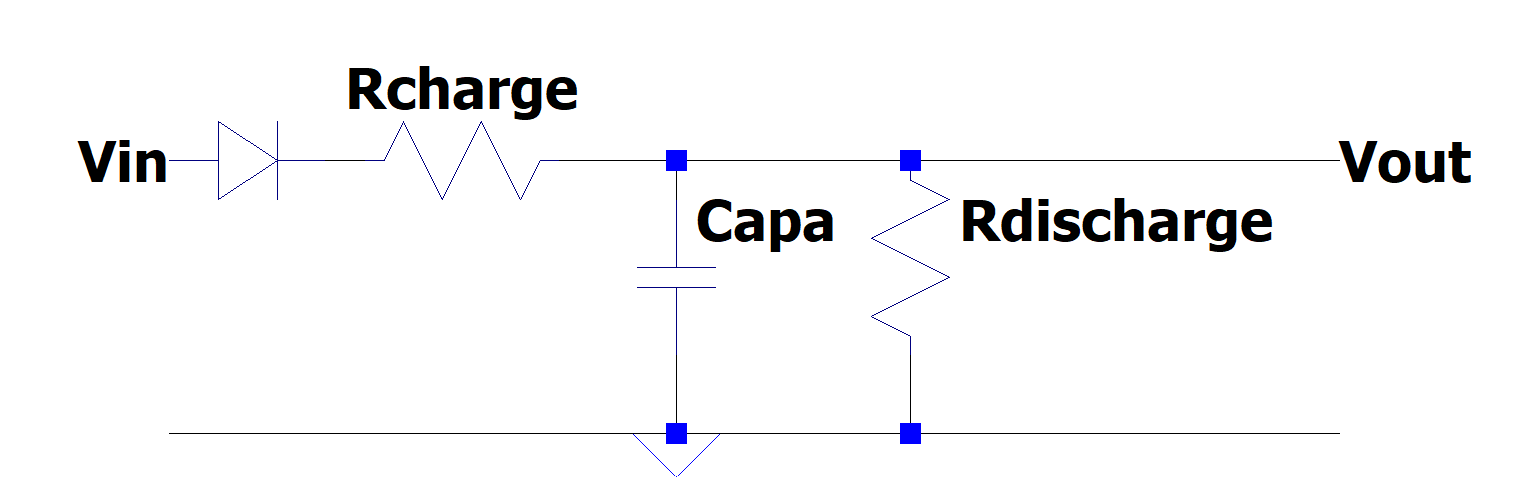

In [38]:
print("#", mag[0].shape, len(t_axis))

Ts_f= np.diff(t_axis ).mean()
print("#", Ts_f)
sig = mag

tch=1e-3
tdis=160e-3

vo=0
voarr=[]
viarr = mag[0]
for i in range(len (viarr)):
    vi = viarr[i]
    if vi<=vo:
        vo= vo-vo*(Ts_f/tdis)
    else: 
        vo= vo-(Ts_f/tch+Ts_f/tdis)*vo+ vi*(Ts_f/tch)
    voarr.append(vo)
        

# (2001,) 2001
# 2.5e-05


In [39]:
%%time
Ts_f= np.diff(t_axis ).mean()



tch=1e-3
tdis=160e-3

QPEAK = []
for k in range(len(mag)):
    vo=0
    voarr=[]
    viarr = mag[k]
    for i in range(len (viarr)):
        vi = viarr[i]
        if vi<=vo:
            vo= vo-vo*(Ts_f/tdis)
        else: 
            vo= vo-(Ts_f/tch+Ts_f/tdis)*vo+ vi*(Ts_f/tch)
        voarr.append(vo)
    QPEAK.append(np.max(voarr))
        

CPU times: total: 2.53 s
Wall time: 5.17 s


In [40]:
len(QPEAK), len(f_axis)

(1250, 1250)

In [41]:
# dbuv = 20*log10(mag*1e6), 1µV = 1e6 volte 
QPEAK = np.array(QPEAK)
QPEAKdb = 20*np.log10(QPEAK*1e6)

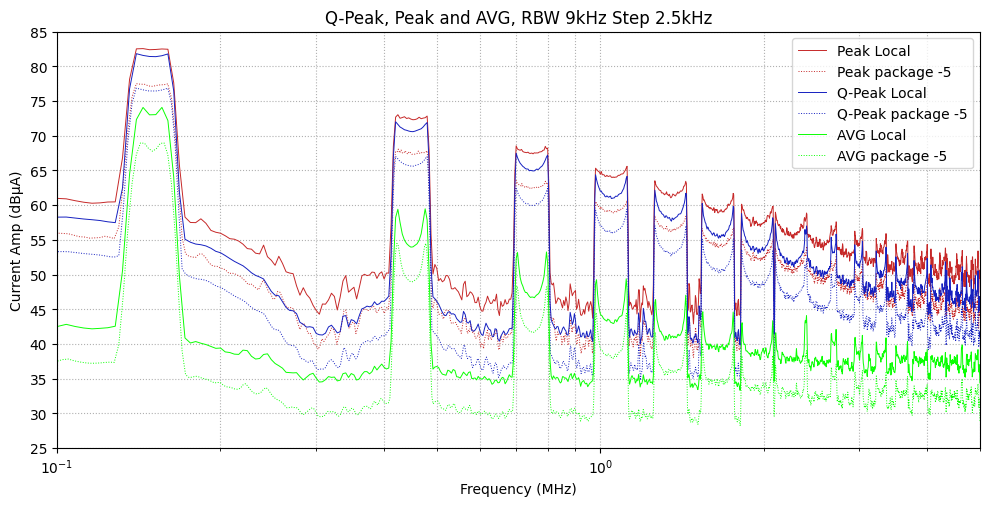

In [47]:
title="Q-Peak, Peak and AVG, RBW 9kHz Step 2.5kHz"
plt.figure(figsize=(10,5))




plt.semilogx(f_axis*1e-6, PEAKdb, label='Peak Local', color=rd, linewidth=0.7)  
plt.semilogx(freqs*1e-6, peak-5, label='Peak package -5', color=rd, linewidth=0.7, linestyle = "dotted")


plt.semilogx(f_axis*1e-6, QPEAKdb, label='Q-Peak Local', color=bl, linewidth=0.7)  
plt.semilogx(freqs*1e-6, qp-5, label='Q-Peak package -5', color=bl, linewidth=0.7, linestyle = "dotted") 


plt.semilogx(f_axis*1e-6, AVGdb, label='AVG Local', color="#0AFF03", linewidth=0.7) 
plt.semilogx(freqs*1e-6, avg-5, label='AVG package -5', color="#0AFF03", linewidth=0.7, linestyle = "dotted")

amax = 85
amin = 25

plt.ylim(amin, amax)
plt.yticks(np.arange(amin, amax+1, 5))
plt.grid(True)

plt.grid(True, which='both', ls=':')
plt.xlabel('Frequency (MHz)')
plt.xlim([0.1, 5])
plt.ylabel('Current Amp (dBµA)')
plt.legend()
plt.tight_layout()
plt.title(title)
plt.show()